<a href="https://colab.research.google.com/github/abuchin/transformer_immune/blob/main/transformer_immune_cells_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-tuning Geneformer for Allen Institutue Immune dataset**

The aim of this Notebook is to use pre-trained transformer models (Geneformer, scGPT) to fine-tune on immune cells derived from Allen Institute Immune atalas (https://apps.allenimmunology.org/aifi/resources/imm-health-atlas/downloads/scrna/). Initially we will fine-tune the model on monocytes.

This project has the following aims:

(i) Fine-tune existing foundational model on example cell-types (monocytes, NK, other cells), derived from different patients.

(ii) Learn the model to predict metadata like age based on data (gene expression profile). We will be predicting 3 groups of age: children, young adults and elderly.


**Install libraries**

In [1]:

!pip install torch
!pip install transformers
!pip install scanpy
!pip install datasets anndata

# Geneformer installation
!git lfs install
!git clone https://huggingface.co/ctheodoris/Geneformer
!pip install ./Geneformer

# install mygene
!pip install mygene

# install scvi
!pip install scvi-tools



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

## Import libraries

In [1]:

# get the standard libraries
import scanpy as sc
import pandas as pd
import numpy as np

import os
import torch
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import json

# transformer libraries
from torch.utils.data import Dataset, random_split
import scvi
from tqdm.notebook import tqdm
from datasets import load_from_disk

# get the standard tokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification



In [4]:

# code to mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Model Fine-Tuning

In this part we will use model evaluation to check how well our fine-tuned model could predict metadata variables. And how good is the model for masked sample generation. We will plot confusion matrix, regression variables and other parameters for the model.

In [2]:

# if GPU available - move to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Upload tokenized data

We will use tokenized data for the model.

### Save pre-processed tokenized data

### Load tokenized dataset

In [3]:

# Get the tokenizer
from geneformer.tokenizer import tokenize_cell
import numpy as np
from datasets import Dataset as HFDataset
import torch
from geneformer.tokenizer import TranscriptomeTokenizer



In [15]:

# load tokenized data
hf_ds = load_from_disk("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/tokenized_adata_nk")


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


### Reload saved adata files

In [16]:

# load adata file
adata_nk = sc.read("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/data/preprocessed/full_data/adata_nk_hvg.h5ad")


In [17]:

# create gene_token_dict

# initialize the tokenizer
tk = TranscriptomeTokenizer()  # init with defaults
gene_token_dict = tk.gene_token_dict  # maps Ensembl ID → token index

# create genes and gene tokens
genes = adata_nk.var_names.to_list()
gene_tokens = np.array([gene_token_dict.get(g, 0) for g in genes], dtype=int)



## Create train and test datasets

In [18]:

# Assuming hf_ds is your Hugging Face Dataset
split_dataset = hf_ds.train_test_split(test_size=0.2, seed=42)

# create train and test ds
train_ds = split_dataset["train"]
test_ds = split_dataset["test"]

# create a small train and test datasets for debugging
small_train_ds = train_ds.shuffle(seed=42).select(range(int(1.0 * len(train_ds))))
small_test_ds = test_ds.shuffle(seed=42).select(range(int(1.0 * len(test_ds))))



### Setting up the model

In this part we will save the model and intermediate steps into the corresponding folders. We will save the model, as well as predicted data.

In [4]:

# clean up CUDA memory (just in case)

import torch, gc

# Clear Python variables
gc.collect()

# Clear CUDA cache
torch.cuda.empty_cache()



### Using pre-trained model for training

In this part we will use pre-trained model for down-stream model classificaiton.

In [56]:

# get the trainer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# number of unique categories
NUM_LABELS=3

# take pre-trained model: Geneformer
model_class = AutoModelForSequenceClassification.from_pretrained(
    "ctheodoris/Geneformer",
    num_labels=NUM_LABELS
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ctheodoris/Geneformer and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:

# Define the training loops

args = TrainingArguments(
    output_dir="./geneformer_clf",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    logging_strategy="steps",
    learning_rate=3e-5,
    logging_steps=50,
    logging_dir="./logs",
    report_to="none"  # or "wandb", "tensorboard" if you want logging
)


In [23]:

# define compute metrics function

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):

    # define predictions
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # clear predictions
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", zero_division=0
    )

    # model accuracy
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [59]:

# create data collator for tokenized data
from geneformer import DataCollatorForCellClassification

# use data collator for encoded gene expression
collator = DataCollatorForCellClassification(
    token_dictionary=gene_token_dict
)


In [60]:

# Instantieate the model trainer
trainer = Trainer(
    model=model_class,
    args=args,
    # using small train and test datasets
    train_dataset=small_train_ds,
    eval_dataset=small_test_ds,
    compute_metrics=compute_metrics,
    data_collator=collator
)


## Freeze the last 2 layers

In this part we will freeze the model layers. To make things simpler we will fix the last layer for the model and allow it to change according to our input.

In [61]:

# 1. Freeze all parameters
for name, param in model_class.base_model.named_parameters():
    param.requires_grad = False

# 2. Unfreeze the last 1 transformer layers
for name, param in model_class.base_model.named_parameters():
    if "encoder.layer" in name:  # works for BERT-style models
        # extract the layer number
        layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
        if layer_num >= (model_class.base_model.config.num_hidden_layers - 2):
            param.requires_grad = True


In [62]:

# check model parameters needed for training
for name, param in model_class.named_parameters():
    if param.requires_grad:
        print(f"{name}: trainable")


bert.encoder.layer.16.attention.self.query.weight: trainable
bert.encoder.layer.16.attention.self.query.bias: trainable
bert.encoder.layer.16.attention.self.key.weight: trainable
bert.encoder.layer.16.attention.self.key.bias: trainable
bert.encoder.layer.16.attention.self.value.weight: trainable
bert.encoder.layer.16.attention.self.value.bias: trainable
bert.encoder.layer.16.attention.output.dense.weight: trainable
bert.encoder.layer.16.attention.output.dense.bias: trainable
bert.encoder.layer.16.attention.output.LayerNorm.weight: trainable
bert.encoder.layer.16.attention.output.LayerNorm.bias: trainable
bert.encoder.layer.16.intermediate.dense.weight: trainable
bert.encoder.layer.16.intermediate.dense.bias: trainable
bert.encoder.layer.16.output.dense.weight: trainable
bert.encoder.layer.16.output.dense.bias: trainable
bert.encoder.layer.16.output.LayerNorm.weight: trainable
bert.encoder.layer.16.output.LayerNorm.bias: trainable
bert.encoder.layer.17.attention.self.query.weight: train

### Model training

In [63]:

# start training!
trainer.train()


/usr/local/lib/python3.11/dist-packages/geneformer/collator_for_classification.py:649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v.clone().detach(), dtype=torch.int64) if isinstance(v, torch.Tensor) else torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Step,Training Loss
50,1.023000
100,0.988900
150,0.980000
200,0.975500
250,0.978000
300,0.963300
350,0.948100
400,0.946800
450,0.935700
500,0.929400


/usr/local/lib/python3.11/dist-packages/geneformer/collator_for_classification.py:649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v.clone().detach(), dtype=torch.int64) if isinstance(v, torch.Tensor) else torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/usr/local/lib/python3.11/dist-packages/geneformer/collator_for_classification.py:649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v.clone().detach(), dtype=torch.int64) if isinstance(v, torch.Tensor) else torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}
/usr/local/lib/python3.11/dist-packages/geneformer/collator_for_classification.py:649: UserWarning: To cop

Step,Training Loss
50,1.023000
100,0.988900
150,0.980000
200,0.975500
250,0.978000
300,0.963300
350,0.948100
400,0.946800
450,0.935700
500,0.929400


TrainOutput(global_step=9290, training_loss=0.7965740571365931, metrics={'train_runtime': 57713.3672, 'train_samples_per_second': 20.599, 'train_steps_per_second': 0.161, 'total_flos': 1.0527519785497805e+18, 'train_loss': 0.7965740571365931, 'epoch': 10.0})

## Save trained model and tokenizer

In [68]:

# save trained model
trainer.save_model("/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/model/trained_model")

# make sure tokenizer is here
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# path where you saved the model
model_path = "/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/model/trained_model"

# save the model
# save the tokenizer using json
with open(f"{model_path}/gene_token_dict.json", "w") as f:
    json.dump(tk.gene_token_dict, f)



## Reload the model

In [21]:

# Reload the saved model

# number of labels
NUM_LABELS=3

model_class = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/Othercomputers/My MacBook Pro (2)/SCIENCE/Projects/immunology_transformer/model/trained_model",
    num_labels=NUM_LABELS
)



## Recreate the model (if model is loaded)

In [25]:

# computer metrics
def compute_metrics(eval_pred):

    # define predictions
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # clear predictions
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", zero_division=0
    )

    # model accuracy
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# data collator

# create data collator for tokenized data
from geneformer import DataCollatorForCellClassification

# use data collator for encoded gene expression
collator = DataCollatorForCellClassification(
    token_dictionary=gene_token_dict
)


In [26]:
# recreate the trainer

# get the trainer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model args
args = TrainingArguments(
    output_dir="./geneformer_clf",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    do_eval=True,
    save_steps=50,
    eval_steps=50,
    logging_steps=50,
    learning_rate=3e-5,
    logging_dir="./logs",
    report_to="none"
)


# Instantieate the trainer
trainer = Trainer(
    model=model_class,
    args=args,
    # using small train and test datasets
    train_dataset=small_train_ds,
    eval_dataset=small_test_ds,
    compute_metrics=compute_metrics,
    data_collator=collator # Make sure data_collator is included
)

### Evaluation of the trained model

Now the model includes gene expression. Let's test its capabilities.

In [27]:

# Recreate compute metrics

# define compute metrics function

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):

    # define predictions
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    # clear predictions
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="weighted", zero_division=0
    )

    # model accuracy
    acc = accuracy_score(labels, predictions)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }




# Plot the results of age classification

In this part we will plot and evaluate the model results.

**Comparison to RF trained on gene expression directly**


In this part we will create a baseline random forest classifier and evaluate its ability to predict age group from expression data directly

In [28]:

# prepare the data for RF model training
X_rf=adata_nk.X.toarray()

# create random data splits
from sklearn.model_selection import train_test_split

# Stratified data split by age group
X_train, X_test, y_train, y_test = train_test_split(X_rf, adata_nk.obs['subject.ageGroup'],
                                              stratify=adata_nk.obs['subject.ageGroup'],
                                              test_size=0.2, random_state=42)


In [29]:

# Train Random forest model and evaluate on X_test
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train the model and print the classificatio report
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)



RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

    Children       0.92      0.12      0.21      4321
 Older Adult       0.56      0.55      0.55     12003
 Young Adult       0.58      0.75      0.65     13397

    accuracy                           0.58     29721
   macro avg       0.69      0.47      0.47     29721
weighted avg       0.62      0.58      0.55     29721



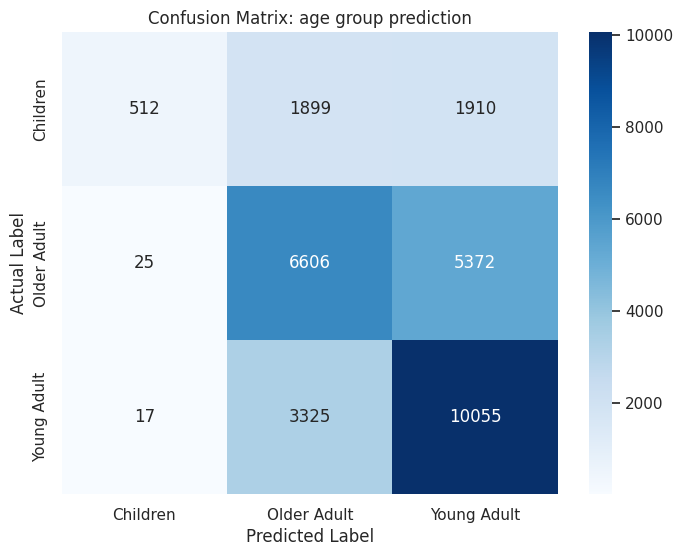

In [30]:

# Predict on the test set
y_pred = rf_model.predict(X_test)

# show the contingency matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# 1. Get class labels from the model
# Using rf_model.classes_ ensures the labels match the matrix order.
class_labels = rf_model.classes_

# 2. Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=class_labels)

# 3. Plot the heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

# Add title and axis labels for clarity
plt.title('Confusion Matrix: age group prediction')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

plt.show()


### Geneformer age group prediction

In this part we will use Geneformer to predict age group from tokenized gene expression data


In [31]:

# get accuracy score
from sklearn.metrics import accuracy_score


In [32]:

# change labels from one dataset to another.
print(test_ds.column_names)

# If the label column is named differently, rename it
if "labels" in test_ds.column_names:
    test_ds = test_ds.rename_column("labels", "label")


['input_ids', 'attention_mask', 'gene_expr', 'labels']


In [33]:

# use small part of the dataset: temporarl
small_test_ds = test_ds.shuffle(seed=42).select(range(int(1.0 * len(test_ds))))

# evalute results on test dataset
preds_output = trainer.predict(small_test_ds)

# create labels
pred_labels = preds_output.predictions.argmax(-1)
true_labels = preds_output.label_ids



/usr/local/lib/python3.11/dist-packages/geneformer/collator_for_classification.py:649: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v.clone().detach(), dtype=torch.int64) if isinstance(v, torch.Tensor) else torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


In [34]:

# show classificaiton performance
from sklearn.metrics import classification_report

# get all unique classes in true and predicted labels
unique_classes = sorted(list(set(np.unique(true_labels)) | set(np.unique(pred_labels))))
target_names = [f"class{i}" for i in unique_classes]

print(classification_report(true_labels, pred_labels, target_names=target_names))


              precision    recall  f1-score   support

      class0       0.57      0.70      0.63      4288
      class1       0.67      0.50      0.57     12124
      class2       0.64      0.74      0.68     13309

    accuracy                           0.63     29721
   macro avg       0.62      0.65      0.63     29721
weighted avg       0.64      0.63      0.63     29721



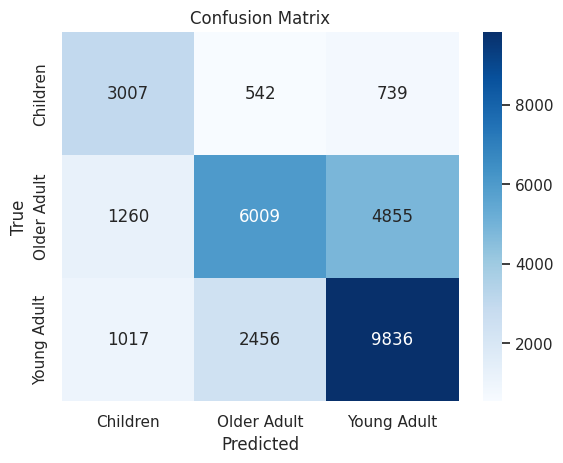

In [35]:

from sklearn.metrics import confusion_matrix
import seaborn as sns


# plot the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Evaluate the model training

In this part we will evaluate the model training speed and see
how well it has been trained and for how long.



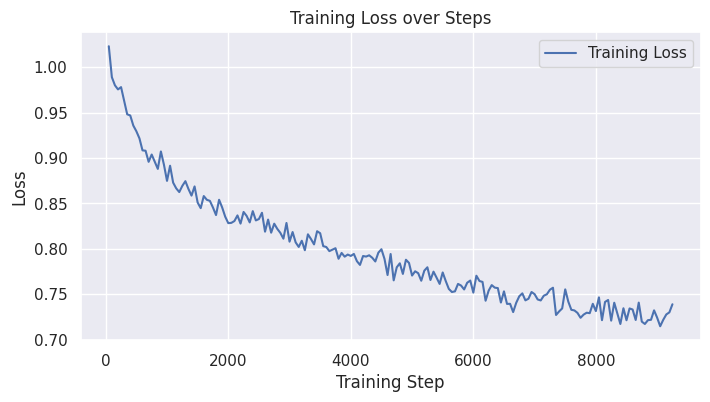

In [88]:

# get a history
history = trainer.state.log_history

# log loss
df_logs = pd.DataFrame(trainer.state.log_history)

df_loss = df_logs[df_logs["loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(df_loss["step"], df_loss["loss"], label="Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# save all requirements
!pip freeze > requirements_model.txt

